In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys


import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')
sys.path.append('../src')
from irish_M_buoy_data import IrishBuoyData

In [2]:
# Step 1: Get your multi-level data
buoy_stations = ['M3']#, 'M3', 'M4', 'M5', 'M6']
all_buoy_data = []

#print("Fetching data from all buoys...")
for station_id in buoy_stations:
    #print(f"Fetching {station_id}...")
    try:
        buoy = IrishBuoyData(station_id=station_id)
        data = buoy.fetch_data(days_back=1875)
        data = data[~data.index.duplicated(keep='first')]
        data = data.drop(columns=['station_id'])
        all_buoy_data.append(data)
        #print(f"  ✓ {station_id}: {len(data)} records")
    except Exception as e:
        print(f"  ✗ {station_id}: Error - {e}")

# Create multi-level DataFrame
df_multi = pd.concat(all_buoy_data, axis=1, keys=buoy_stations)
df_multi = df_multi.interpolate(method='time', limit=3).fillna(method='ffill').fillna(method='bfill')

# Step 2: Flatten to single-level columns for XGBoost
df_flat = df_multi.copy()
df_flat.columns = ['_'.join(col).strip() for col in df_flat.columns.values]

/var/folders/1j/0q6grdh110z1c008s2nrczkm0000gn/T/ipykernel_45985/2195356515.py:20: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_multi = df_multi.interpolate(method='time', limit=3).fillna(method='ffill').fillna(method='bfill')


In [3]:
df_flat[['M3_WaveHeight (meters)']].tail()

,M3_WaveHeight (meters)
time (UTC),
2025-12-29 09:00:00+00:00,1.641
2025-12-29 10:00:00+00:00,1.523
2025-12-29 11:00:00+00:00,1.641
2025-12-29 12:00:00+00:00,1.523
2025-12-29 13:00:00+00:00,1.641


In [4]:
df = df_flat[['M3_WaveHeight (meters)']].copy()
df.index.name = 'Datetime'
df.index = pd.to_datetime(df.index)

In [5]:
df.head()

,M3_WaveHeight (meters)
Datetime,
2020-11-10 15:00:00+00:00,2.734
2020-11-10 16:00:00+00:00,3.125
2020-11-10 17:00:00+00:00,3.203
2020-11-10 18:00:00+00:00,3.281
2020-11-10 19:00:00+00:00,3.672


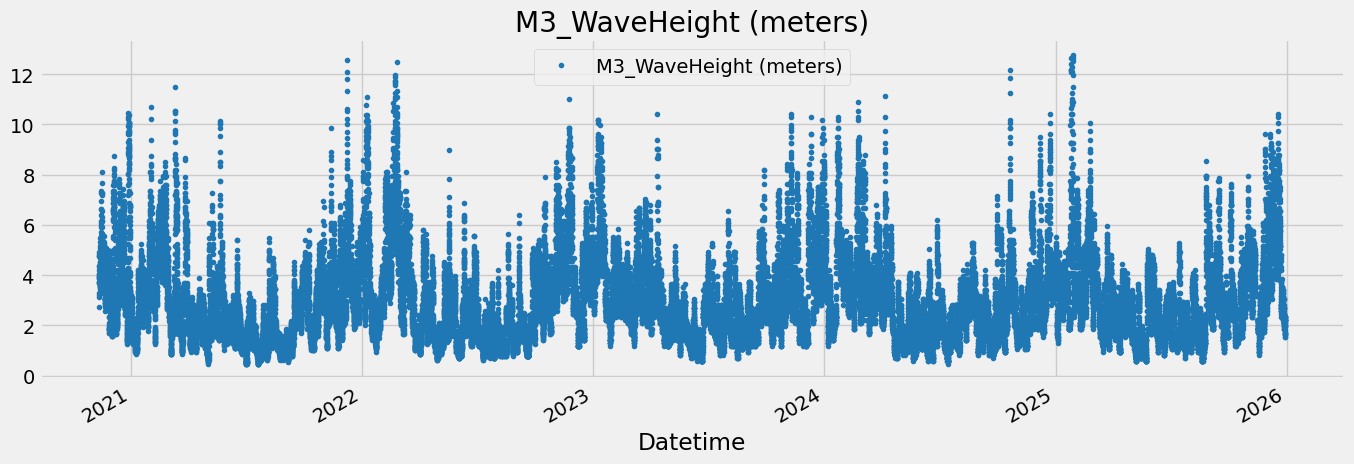

In [6]:
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='M3_WaveHeight (meters)')
plt.show()

### Train / Test split

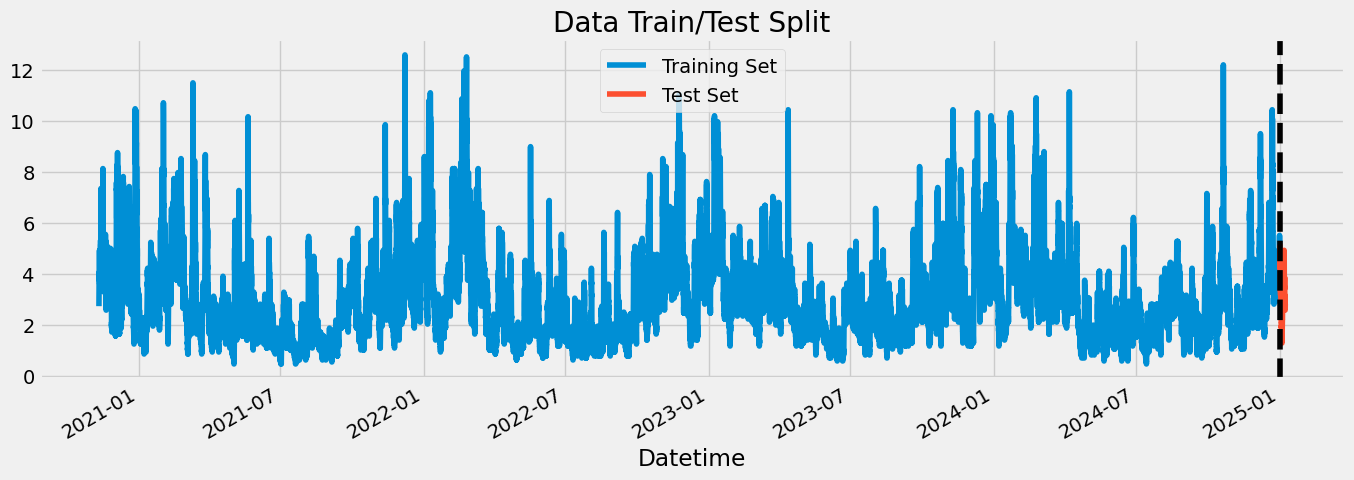

In [7]:
train = df.loc[df.index < '01-01-2025']
# Get one week starting from Jan 1, 2025
test = df.loc[(df.index >= '2025-01-01') & (df.index < '2025-01-08')]

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2025', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

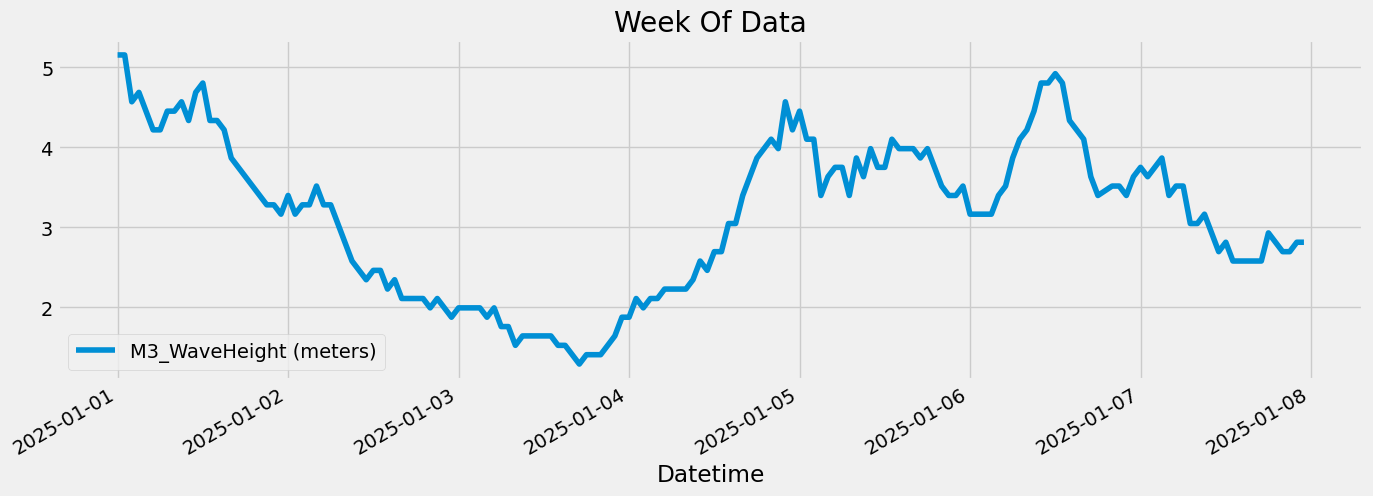

In [8]:
df.loc[(df.index >= '2025-01-01') & (df.index < '2025-01-08')] \
    .plot(figsize=(15, 5), title='Week Of Data')
plt.show()

### Feature Creation

In [9]:
'''def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['dayofyear'] = df.index.dayofyear
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)'''

def create_features(df):
    """
    Create comprehensive time series features based on time series index.
    """
    df = df.copy()
    
    # === Time-based features ===
    df['hour'] = df.index.hour
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['dayofyear'] = df.index.dayofyear
    df['weekofyear'] = df.index.isocalendar().week
    
    # === Cyclical encoding (important for time features!) ===
    # Hour (0-23)
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    
    
    # Month (1-12)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    
    # Day of year (1-365)
    df['dayofyear_sin'] = np.sin(2 * np.pi * df['dayofyear'] / 365.25)
    df['dayofyear_cos'] = np.cos(2 * np.pi * df['dayofyear'] / 365.25)
    
    
    # Season
    df['season'] = df['month'] % 12 // 3 + 1  # 1=Winter, 2=Spring, 3=Summer, 4=Fall


    return df

# Apply features
df = create_features(df)

print(f"Original features: {df_flat.shape[1]}")
print(f"New features: {df.shape[1]}")
print(f"Added {df.shape[1] - df_flat.shape[1]} features!")

Original features: 6
New features: 13
Added 7 features!


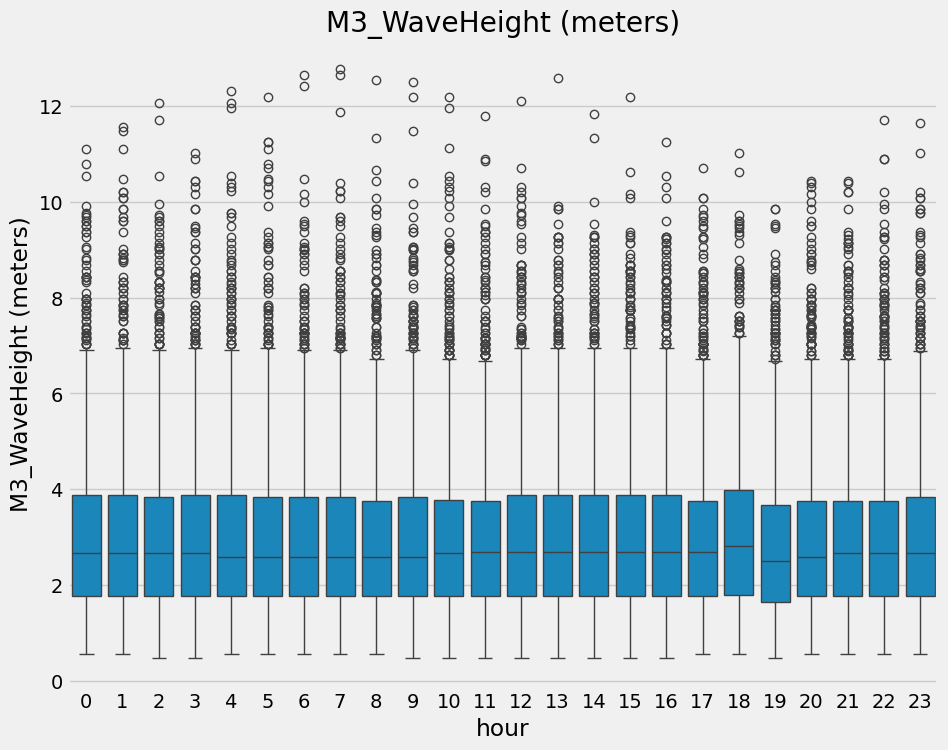

In [10]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='M3_WaveHeight (meters)')
ax.set_title('M3_WaveHeight (meters)')
plt.show()

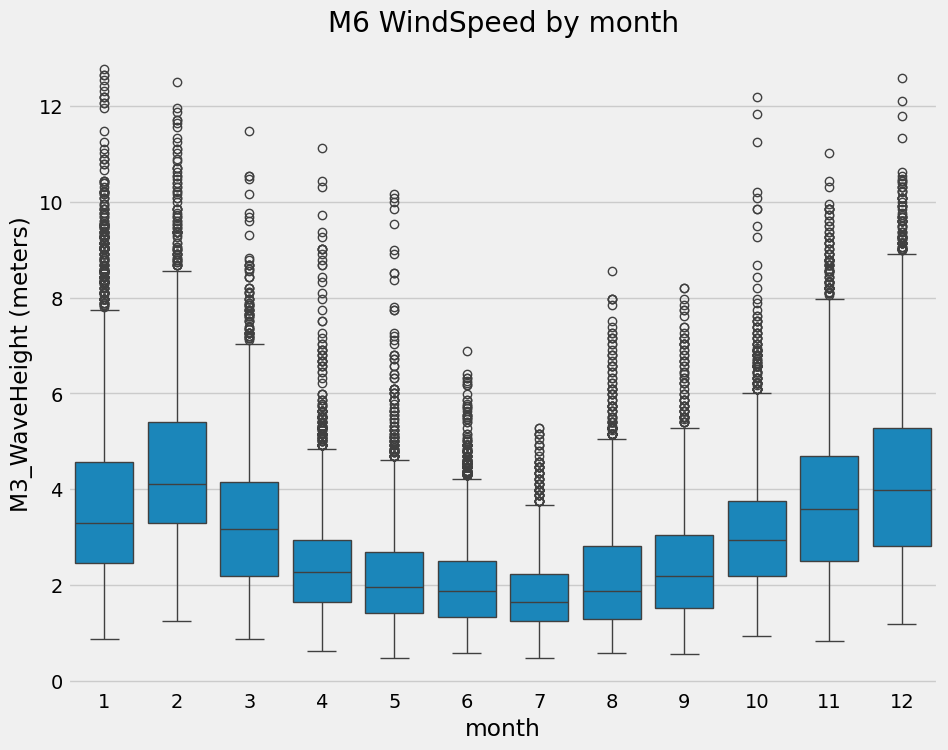

In [11]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='M3_WaveHeight (meters)')
ax.set_title('M6 WindSpeed by month')
plt.show()

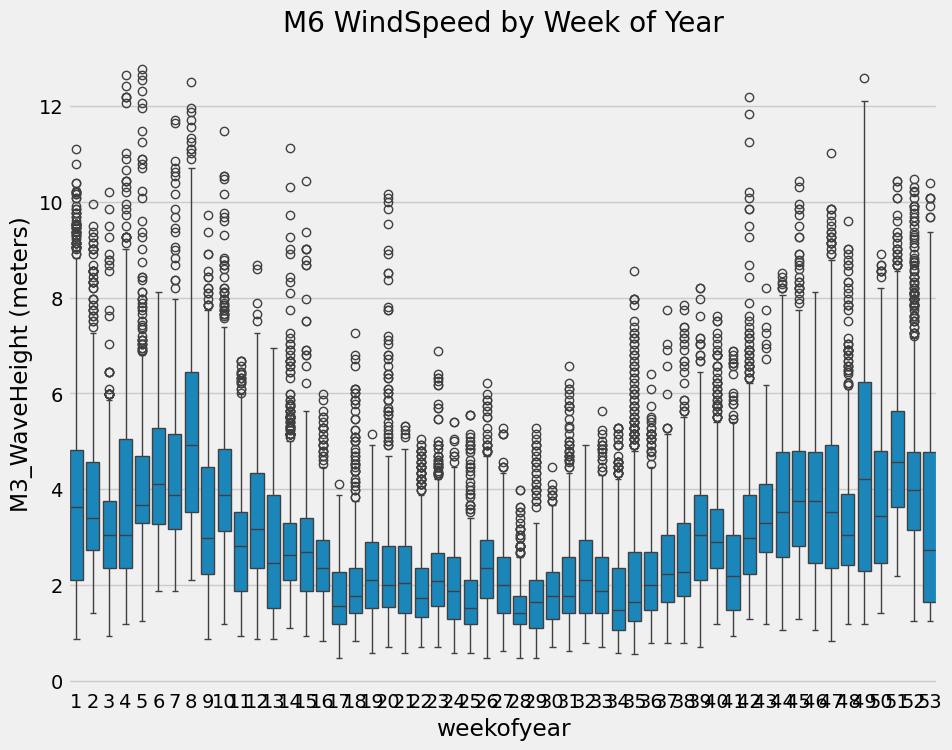

In [12]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='weekofyear', y='M3_WaveHeight (meters)')
ax.set_title('M6 WindSpeed by Week of Year')
plt.show()

### Create Our Model

In [13]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'quarter', 'month', 'weekofyear',
            'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 
            'dayofyear_sin', 'dayofyear_cos', 'season']
TARGET = 'M3_WaveHeight (meters)'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [14]:
'''reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)'''

# REPLACE WITH THIS NEW CODE:
model = xgb.XGBRegressor(
    objective='reg:squarederror',  # Updated from deprecated 'reg:linear'
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=5,                   # Increased from 3
    min_child_weight=3,            # NEW - adds regularization
    subsample=0.8,                 # NEW - sample 80% of data
    colsample_bytree=0.8,          # NEW - sample 80% of features
    reg_alpha=0.1,                 # NEW - L1 regularization
    reg_lambda=1.0,                # NEW - L2 regularization
    gamma=0.1,                     # NEW - minimum loss reduction
    early_stopping_rounds=50,
    random_state=42,
    n_jobs=-1
)

model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],  # Keep your X_test, y_test
    verbose=True
)

# Then use 'model' instead of 'reg' for predictions:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

[0]	validation_0-rmse:1.66287	validation_1-rmse:0.97952
[1]	validation_0-rmse:1.65700	validation_1-rmse:0.97834
[2]	validation_0-rmse:1.65126	validation_1-rmse:0.97732
[3]	validation_0-rmse:1.64596	validation_1-rmse:0.97619
[4]	validation_0-rmse:1.64041	validation_1-rmse:0.97534
[5]	validation_0-rmse:1.63489	validation_1-rmse:0.97379
[6]	validation_0-rmse:1.62941	validation_1-rmse:0.97413
[7]	validation_0-rmse:1.62406	validation_1-rmse:0.97480
[8]	validation_0-rmse:1.61901	validation_1-rmse:0.97371
[9]	validation_0-rmse:1.61372	validation_1-rmse:0.97445
[10]	validation_0-rmse:1.60878	validation_1-rmse:0.97359
[11]	validation_0-rmse:1.60376	validation_1-rmse:0.97524
[12]	validation_0-rmse:1.59921	validation_1-rmse:0.97484
[13]	validation_0-rmse:1.59449	validation_1-rmse:0.97445
[14]	validation_0-rmse:1.58984	validation_1-rmse:0.97433
[15]	validation_0-rmse:1.58530	validation_1-rmse:0.97405
[16]	validation_0-rmse:1.58068	validation_1-rmse:0.97507
[17]	validation_0-rmse:1.57605	validation

### Feature Importance

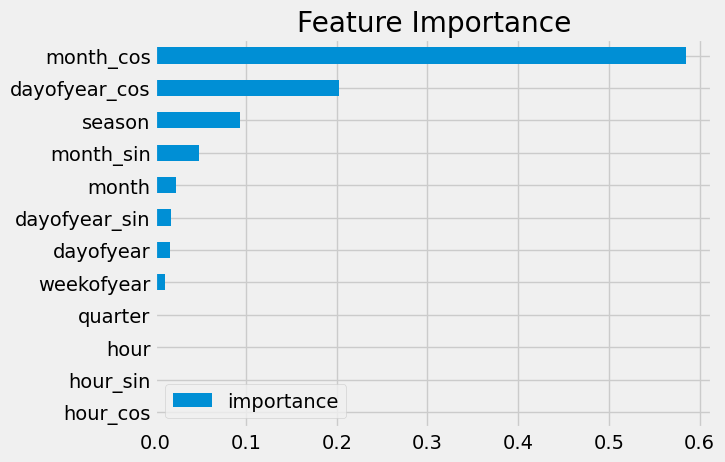

In [15]:
fi = pd.DataFrame(data=model.feature_importances_,
             index=model.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

### Forcast Test

In [16]:
test.tail()

,M3_WaveHeight (meters),hour,quarter,month,dayofyear,weekofyear,hour_sin,hour_cos,month_sin,month_cos,dayofyear_sin,dayofyear_cos,season
Datetime,,,,,,,,,,,,,
2025-01-07 18:00:00+00:00,2.930,18,1,1,7,2,-1.000000,-1.836970e-16,0.5,0.866025,0.120126,0.992759,1
2025-01-07 20:00:00+00:00,2.695,20,1,1,7,2,-0.866025,5.000000e-01,0.5,0.866025,0.120126,0.992759,1
2025-01-07 21:00:00+00:00,2.695,21,1,1,7,2,-0.707107,7.071068e-01,0.5,0.866025,0.120126,0.992759,1
2025-01-07 22:00:00+00:00,2.813,22,1,1,7,2,-0.500000,8.660254e-01,0.5,0.866025,0.120126,0.992759,1
2025-01-07 23:00:00+00:00,2.813,23,1,1,7,2,-0.258819,9.659258e-01,0.5,0.866025,0.120126,0.992759,1


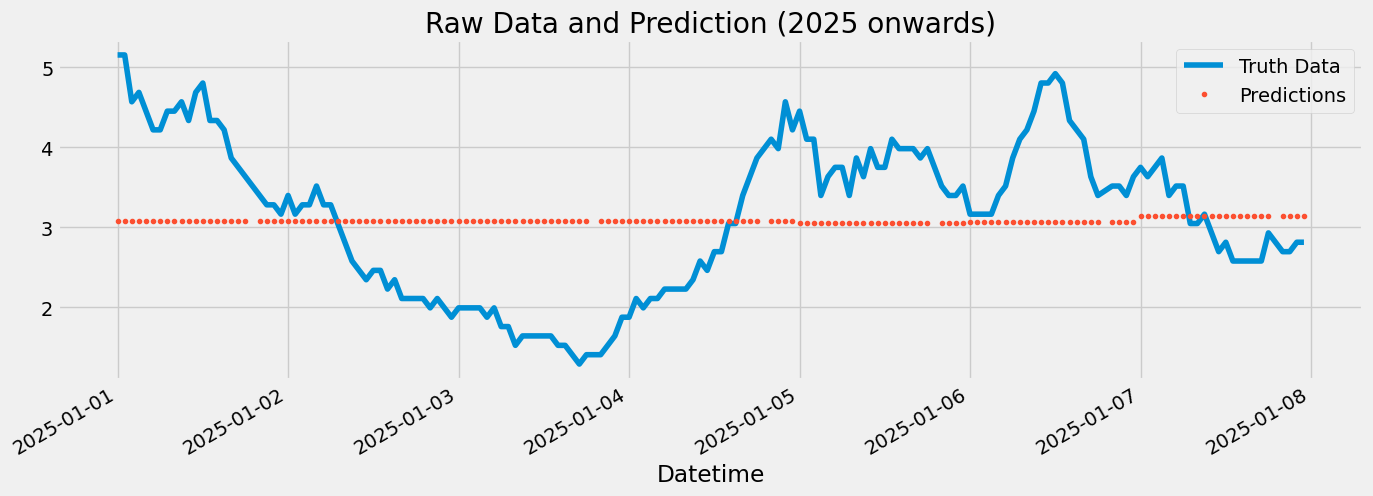

In [17]:
test['prediction'] = model.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)

# Filter for 2025 onwards
df_2025 = df.loc[(df.index >= '2025-01-01') & (df.index < '2025-01-08')]

# Plot only 2025 data
ax = df_2025[['M3_WaveHeight (meters)']].plot(figsize=(15, 5))
df_2025['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction (2025 onwards)')
plt.show()

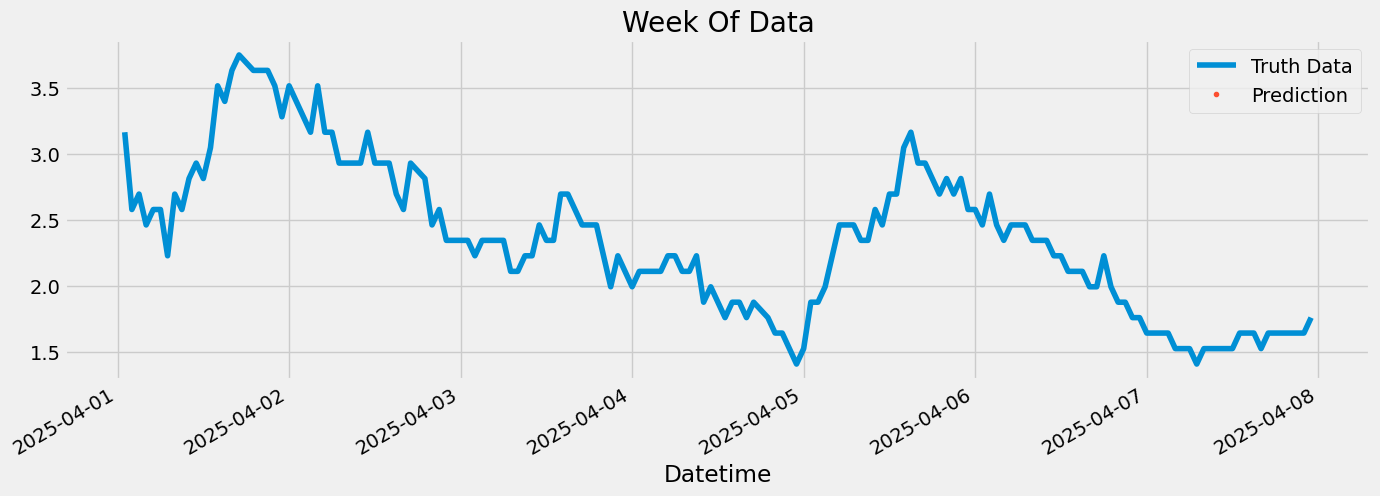

In [18]:
# Use consistent date format: YYYY-MM-DD
ax = df.loc[(df.index > '2025-04-01') & (df.index < '2025-04-08')]['M3_WaveHeight (meters)'] \
    .plot(figsize=(15, 5), title='Week Of Data')

# Use SAME date range for predictions
df.loc[(df.index > '2025-04-01') & (df.index < '2025-04-08')]['prediction'] \
    .plot(ax=ax, style='.')  # Add ax=ax to plot on same axes

plt.legend(['Truth Data','Prediction'])
plt.show()